In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

from kgcnn.literature.GNNExplain import GNNExplainer, GNNInterface
# from kgcnn.utils.adj import precompute_adjacency_scaled, convert_scaled_adjacency_to_list, add_self_loops_to_edge_indices
from kgcnn.literature.GCN import make_gcn
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from kgcnn.utils.learning import lr_lin_reduction

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering

from kgcnn.data.mutagen.mutagenicity import mutagenicity_graph

Keras utils: Register custom activation:  {'leaky_softplus': <function leaky_softplus at 0x0000021CC857D550>, 'shifted_softplus': <function shifted_softplus at 0x0000021CC857D430>, 'softplus2': <function softplus2 at 0x0000021CC857D4C0>}


## Load data

In [2]:
labels, nodes, edge_indices, edges, atoms = mutagenicity_graph()
for i in range(len(labels)):
    # edge_indices[i], edges[i] = add_self_loops_to_edge_indices(edge_indices[i], np.expand_dims(edges[i],axis=-1))
    edges[i] = np.expand_dims(edges[i], axis=-1).astype(np.float32) # Make edge feature dimension
for i in range(len(labels)):
    nodes[i] = np.array(
        np.expand_dims(nodes[i],axis=-1) == np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
                        , dtype=np.int) # Make One-Hot encoding

# Train Test split
labels_train, labels_test, nodes_train, nodes_test, edges_train, edges_test, edge_indices_train, edge_indices_test = train_test_split(
    labels, nodes, edges, edge_indices,  train_size=0.8, random_state=1)

# Convert to tf.RaggedTensor or tf.tensor
# a copy of the data is generated by ragged_tensor_from_nested_numpy()
nodes_train, edges_train, edge_indices_train = ragged_tensor_from_nested_numpy(
    nodes_train), ragged_tensor_from_nested_numpy(edges_train), ragged_tensor_from_nested_numpy(
    edge_indices_train)

nodes_test, edges_test, edge_indices_test = ragged_tensor_from_nested_numpy(
    nodes_test), ragged_tensor_from_nested_numpy(edges_test), ragged_tensor_from_nested_numpy(
    edge_indices_test)

xtrain = nodes_train, edges_train, edge_indices_train
xtest = nodes_test, edges_test, edge_indices_test
ytrain = np.expand_dims(labels_train, axis=-1)
ytest = np.expand_dims(labels_test, axis=-1)

Database path: C:\Users\Patrick\.kgcnn\data\mutagen
Dataset found ... done
Directory for extraction exists ... done
Not extracting Zip File ... stopped
Checking Database...
Removing unconnected {'H': 66} from molecule 38
Removing unconnected {'H': 7} from molecule 133
Removing unconnected {'H': 9} from molecule 220
Removing unconnected {'H': 17} from molecule 246
Removing unconnected {'H': 170, 'C': 52, 'N': 17, 'O': 24, 'S': 4} from molecule 278
Removing unconnected {'H': 63} from molecule 296
Removing unconnected {'H': 26} from molecule 302
Removing unconnected {'H': 126, 'C': 42, 'N': 1, 'O': 4} from molecule 339
Removing unconnected {'H': 13} from molecule 743
Removing unconnected {'H': 10} from molecule 783
Removing unconnected {'H': 24} from molecule 1085
Removing unconnected {'H': 168, 'C': 50, 'N': 19, 'O': 20, 'S': 2} from molecule 1233
Removing unconnected {'H': 73} from molecule 1525
Removing unconnected {'H': 99, 'C': 7, 'N': 1, 'Cl': 1} from molecule 1609
Removing unconnec

## Make and train GCN

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
node_input (InputLayer)         [(None, None, 14)]   0                                            
__________________________________________________________________________________________________
dense_ragged (DenseRagged)      (None, None, 64)     960         node_input[0][0]                 
__________________________________________________________________________________________________
edge_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
edge_index_input (InputLayer)   [(None, None, 2)]    0                                            
______________________________________________________________________________________________

C:\Users\Patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\Patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn_2/gather_nodes_outgoing_2/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/gcn_2/gather_nodes_outgoing_2/Reshape:0", shape=(None, 64), dtype=float32), dense_shape

109/109 - 3s - loss: 0.6513 - accuracy: 0.6183
Epoch 2/150
109/109 - 1s - loss: 0.6118 - accuracy: 0.6820
Epoch 3/150
109/109 - 1s - loss: 0.5964 - accuracy: 0.6832
Epoch 4/150
109/109 - 1s - loss: 0.5782 - accuracy: 0.7042
Epoch 5/150
109/109 - 1s - loss: 0.5596 - accuracy: 0.7172
Epoch 6/150
109/109 - 1s - loss: 0.5536 - accuracy: 0.7256
Epoch 7/150
109/109 - 1s - loss: 0.5429 - accuracy: 0.7218
Epoch 8/150
109/109 - 1s - loss: 0.5322 - accuracy: 0.7371
Epoch 9/150
109/109 - 1s - loss: 0.5250 - accuracy: 0.7400
Epoch 10/150
109/109 - 3s - loss: 0.5165 - accuracy: 0.7414 - val_loss: 0.5275 - val_accuracy: 0.7431
Epoch 11/150
109/109 - 1s - loss: 0.5143 - accuracy: 0.7483
Epoch 12/150
109/109 - 1s - loss: 0.5080 - accuracy: 0.7457
Epoch 13/150
109/109 - 1s - loss: 0.4974 - accuracy: 0.7622
Epoch 14/150
109/109 - 1s - loss: 0.4880 - accuracy: 0.7674
Epoch 15/150
109/109 - 1s - loss: 0.4832 - accuracy: 0.7694
Epoch 16/150
109/109 - 1s - loss: 0.4806 - accuracy: 0.7694
Epoch 17/150
109/10

109/109 - 1s - loss: 0.2034 - accuracy: 0.9173
Epoch 130/150
109/109 - 1s - loss: 0.1804 - accuracy: 0.9265 - val_loss: 0.8899 - val_accuracy: 0.7846
Epoch 131/150
109/109 - 1s - loss: 0.1801 - accuracy: 0.9285
Epoch 132/150
109/109 - 1s - loss: 0.1740 - accuracy: 0.9308
Epoch 133/150
109/109 - 1s - loss: 0.1802 - accuracy: 0.9297
Epoch 134/150
109/109 - 1s - loss: 0.1561 - accuracy: 0.9395
Epoch 135/150
109/109 - 1s - loss: 0.1725 - accuracy: 0.9317
Epoch 136/150
109/109 - 1s - loss: 0.1659 - accuracy: 0.9323
Epoch 137/150
109/109 - 1s - loss: 0.1557 - accuracy: 0.9328
Epoch 138/150
109/109 - 1s - loss: 0.1666 - accuracy: 0.9311
Epoch 139/150
109/109 - 1s - loss: 0.1673 - accuracy: 0.9305
Epoch 140/150
109/109 - 1s - loss: 0.1514 - accuracy: 0.9392 - val_loss: 0.8755 - val_accuracy: 0.7892
Epoch 141/150
109/109 - 1s - loss: 0.1514 - accuracy: 0.9429
Epoch 142/150
109/109 - 1s - loss: 0.1617 - accuracy: 0.9325
Epoch 143/150
109/109 - 1s - loss: 0.1708 - accuracy: 0.9314
Epoch 144/150
1

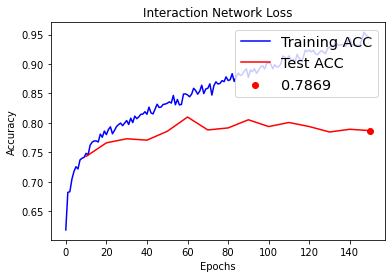

In [3]:
model = make_gcn(
    input_node_shape=[None,14],
    input_edge_shape=[None, 1],
    input_embedd={'input_node_vocab': 55, "input_node_embedd": 64},
    # Output
    output_embedd={"output_mode": 'graph', "output_type": 'padded'},
    output_mlp={"use_bias": [True, True, False], "units": [140, 70, 1], "activation": ['relu', 'relu', 'sigmoid']},
    # model specs
    depth=3,
    gcn_args={"units": 64, "use_bias": True, "activation": "relu", "has_unconnected": True, "is_sorted": False, "pooling_method": 'segment_mean'}
)

# Set learning rate and epochs
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 150
epomin = 100
epostep = 10

# Compile model with optimizer and loss
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
cbks = tf.keras.callbacks.LearningRateScheduler(lr_lin_reduction(learning_rate_start, learning_rate_stop, epomin, epo))
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy'])
print(model.summary())

# Start and time training
start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=2
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

# Get loss from history
trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])
acc_valid = testlossall[-1]

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.savefig('gcn_explain_mutag_3.png')
plt.show()

## Implement the ExplainableGNN from GNNInterface

In [5]:
class ExplainableGCN(GNNInterface):

    def __init__(self, gnn_model, **kwargs):
        super(ExplainableGCN, self).__init__()
        self.gnn_model = gnn_model

    def predict(self, gnn_input, masking_info=None):
        return self.gnn_model(gnn_input, training=False)[0]

    def masked_predict(self, gnn_input, edge_mask, feature_mask, node_mask, training=False):
        node_input, edge_input, edge_index_input = gnn_input

        masked_edge_input = tf.ragged.map_flat_values(tf.math.multiply, edge_input, edge_mask)
        masked_feature_input = tf.ragged.map_flat_values(tf.math.multiply, tf.dtypes.cast(node_input, tf.float32),
                                                         tf.transpose(feature_mask))
        masked_node_feature_input = tf.ragged.map_flat_values(tf.math.multiply, masked_feature_input, node_mask)
        masked_pred = \
        self.gnn_model([masked_node_feature_input, masked_edge_input, edge_index_input], training=training)[0]

        return masked_pred

    def get_number_of_nodes(self, gnn_input):
        node_input, _, _ = gnn_input
        return node_input[0].shape[0]

    def get_number_of_node_features(self, gnn_input):
        node_input, _, _ = gnn_input
        return node_input.shape[2]

    def get_number_of_edges(self, gnn_input):
        _, edge_input, _ = gnn_input
        return edge_input[0].shape[0]

    def get_explanation(self, gnn_input, edge_mask, feature_mask, node_mask):
        edge_relevance = np.array(edge_mask[:, 0])
        node_relevance = np.array(node_mask[:, 0])
        feature_relevance = np.array(feature_mask[:, 0])
        features = np.array(gnn_input[0][0])
        edges = np.array(gnn_input[2][0])
        graph = nx.Graph()
        for i, f in enumerate(features):
            graph.add_node(i, features=f, relevance=node_relevance[i])
        for i, e in enumerate(edges):
            if edge_relevance is None:
                graph.add_edge(e[0], e[1])
            else:
                graph.add_edge(e[0], e[1], relevance=edge_relevance[i])
        return graph, feature_relevance

    def present_explanation(self, explanation, threshold=0.5):
        graph = explanation[0]
        # element_labels = np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
        element_labels = ['H', 'Li', 'C', 'N', 'O', 'F', 'Na', 'P', 'S', 'Cl', 'K', 'Ca', 'Br', 'I']
        important_edges = []
        color_map = []
        node_color_map = []
        node_labels = {}
        for (u, v, relevance) in graph.edges.data('relevance'):
            relevance = min(relevance + 0.1, 1.0)
            color_map.append((0, 0, 0, relevance))
        for n, f in graph.nodes.data('features'):
            element = np.argmax(f)
            r, g, b, a = plt.get_cmap('tab20')(element)
            node_color_map.append((r, g, b, graph.nodes[n]['relevance']))
            node_labels[n] = (element_labels[element])
        if np.all(explanation[1] == 1):
            nx.draw_kamada_kawai(graph, edge_color=color_map, labels=node_labels, node_color=node_color_map)
        else:
            f, axs = plt.subplots(2, figsize=(8, 12))
            nx.draw_kamada_kawai(graph, ax=axs[0], edge_color=color_map, labels=node_labels, node_color=node_color_map)
            bar_colors = [plt.get_cmap('tab20')(element) for element in np.arange(14)]
            axs[1].bar(np.array(element_labels), explanation[1], color=bar_colors)

Instanciate a Explainable GNN:

In [6]:
explainable_gcn = ExplainableGCN(model)
compile_options = {'loss': 'binary_crossentropy', 'optimizer': tf.keras.optimizers.Adam(lr=0.2)}
fit_options={'epochs': 100, 'batch_size': 1, 'verbose': 0}
gnnexplaineroptimizer_options = {'edge_mask_loss_weight': 0.001,
                 'edge_mask_norm_ord': 1,
                 'feature_mask_loss_weight': 0,
                 'feature_mask_norm_ord': 1,
                 'node_mask_loss_weight': 0,
                 'node_mask_norm_ord': 1}

explainer = GNNExplainer(explainable_gcn,
                              compile_options=compile_options,
                              fit_options=fit_options,
                              gnnexplaineroptimizer_options=gnnexplaineroptimizer_options)

inspection_result = explainer.explain([tensor[776:777] for tensor in xtest], inspection=True)

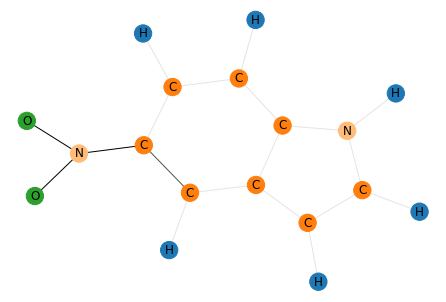

In [7]:
explainer.present_explanation(explainer.get_explanation(), threshold=0.5)

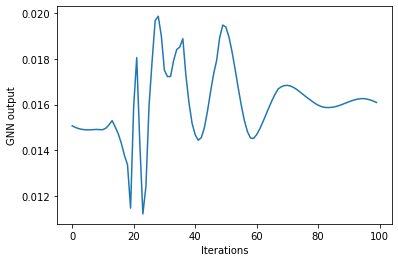

In [8]:
# Plot predicion
plt.figure()
plt.plot(inspection_result['predictions'])
plt.xlabel('Iterations')
plt.ylabel('GNN output')
plt.show()

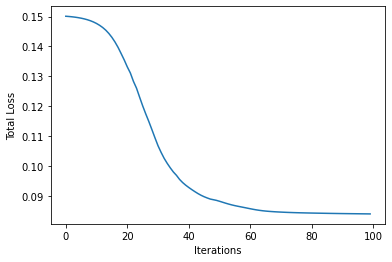

In [9]:
# PLot loss
plt.figure()
plt.plot(inspection_result['total_loss'])
plt.xlabel('Iterations')
plt.ylabel('Total Loss')
plt.show()

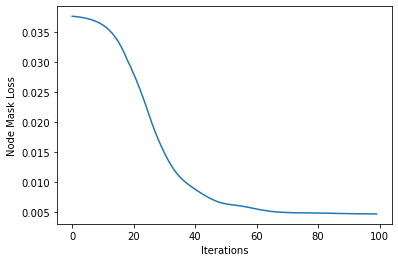

In [10]:
# Plot Edge Mask loss
plt.figure()
plt.plot(inspection_result['edge_mask_loss'])
plt.xlabel('Iterations')
plt.ylabel('Node Mask Loss')
plt.show()

sample 200 mutagenic molecules:

In [11]:
pred = model.predict(xtest)[:,0]
sampled_mutagenic_molecules = np.random.choice(np.argwhere(pred < 0.5)[:,0], 200)
print(sampled_mutagenic_molecules)

[152 465  72 691 786 505 278 850 433 418 281 617 442 511 562  53 850 388
 763 118 357 756 689 367 611 423 811 534 599 567 596 719 300 117 412 756
 620 465 245 832 618 113 697 335  17 497 643 835 133 494 230 328 143 468
 415 551 742  18 496 339 762 697 372 408 427 517 627 151 309 258 413 694
 839 245 368 505  86 130 416  99 472 733 409  37 369 515 448 711 762 115
 328 727 551 281 427  70  44 824 660 586 289  59 730 283 310 676 264 494
 174  64 673 861 729 524 778 284 811 760 825   9 334 595 628 152 430 321
 335 260 244 272 833 588 659 727  34 830 706  21 296 575 146 599 456 484
 119 468 103 622 297 177  21 743 622 199 760 324  91 106 850 347 694 693
 443 760 119  13 652 387 365 199 125 175 786 807 443 466  67 702 421 347
 668  49 297 806 737 490 146 509 643 639 258 178 170 460 604 465 272 189
 452 702]


Generate explanations for all those 50 molecules (this will take a while):

In [12]:
explanations = []
for i,mol_index in enumerate(sampled_mutagenic_molecules):
    explainer.explain([tensor[mol_index:mol_index+1] for tensor in xtest])
    print(i, end=',')
    explanations.append(explainer.get_explanation())

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,

We transform the explanation graphs to vectors, in order to apply a cluster algorithm on the explanation vectors:

In [13]:
def explanation_to_vector(explanation):
    graph = explanation[0]
    bond_matrix = np.zeros((14,14))
    for (u, v, relevance) in graph.edges.data('relevance'):
        atom1 = np.argwhere(graph.nodes[u]['features']==1)[0]
        atom2 = np.argwhere(graph.nodes[v]['features']==1)[0]
        bond_matrix[atom1, atom2] += relevance
        bond_matrix[atom2, atom1] += relevance
    bond_vector = bond_matrix[np.triu_indices(bond_matrix.shape[0])]
    bond_vector = bond_vector / np.sum(bond_vector)
    return bond_vector
explanation_vectors = [explanation_to_vector(expl) for expl in explanations]

a dendogram of the explanation vectors:

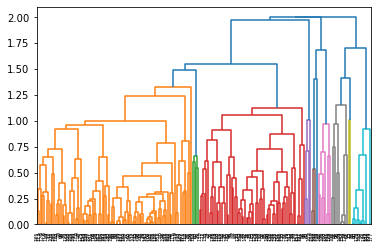

In [14]:
plt.figure()
linked = linkage(explanation_vectors, 'complete', metric='cityblock')
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

Print one representative graph explanation for each cluster:

(97, 105)


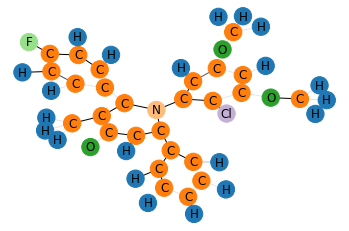

(4, 105)


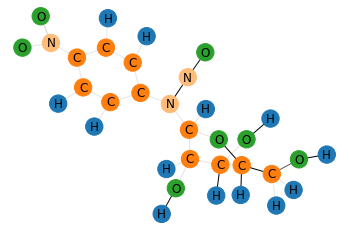

(12, 105)


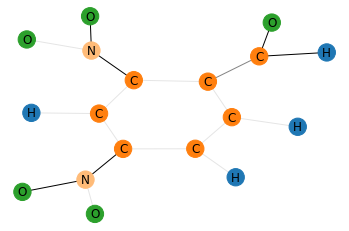

(4, 105)


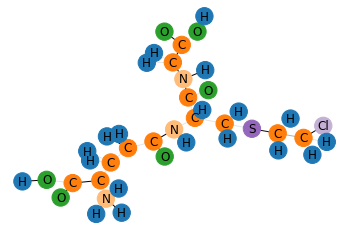

(12, 105)


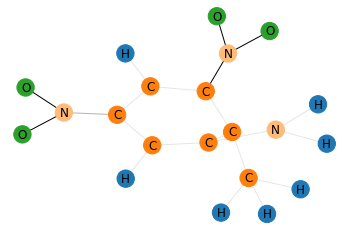

(8, 105)


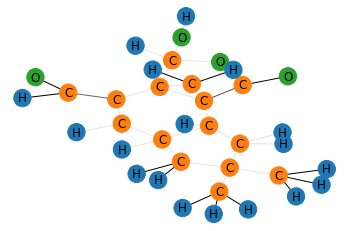

(63, 105)


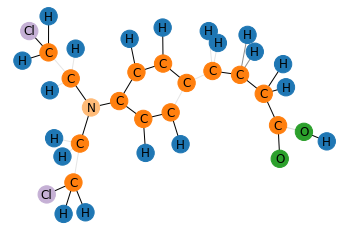

In [15]:
num_clusters = 7
db = AgglomerativeClustering(n_clusters=num_clusters, affinity='manhattan', linkage='complete').fit(explanation_vectors)
vector_clusters = []
explanation_clusters = []
for cluster_ind in range(num_clusters):
    plt.figure()
    vector_cluster = np.array([explanation_vectors[i] for i in np.argwhere(db.labels_ == cluster_ind)[:,0]])
    vector_clusters.append(vector_cluster)
    explanation_cluster = [explanations[i] for i in np.argwhere(db.labels_ == cluster_ind)[:,0]]
    explanation_clusters.append(explanation_cluster)
    cluster_mean = np.mean(vector_cluster, axis=0)
    dist = cdist(np.array([cluster_mean]), vector_cluster)[0]
    print(vector_cluster.shape)
    ax = plt.subplot()
    explainer.present_explanation(explanation_cluster[np.argmin(dist)])
    plt.show()